Install and import dependencies

In [1]:
#import dependecies
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

Build data loading function

In [2]:
Capuchin_File = os.path.join('data','Parsed_Capuchinbird_Clips','XC3776-3.wav')
Not_Capuchin_File = os.path.join('data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

In [3]:
def load_wav_16k_mono(filename):
    #load contents of file
    file_contents = tf.io.read_file(filename)

    #decode file
    wav, sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)

    #remove trailing axis
    wav = tf.squeeze(wav,axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    #Goes from 44100HZ to 16000HZ
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
#plot a wave

wav_capuchin = load_wav_16k_mono(Capuchin_File)
wav_not_capuchin = load_wav_16k_mono(Not_Capuchin_File)


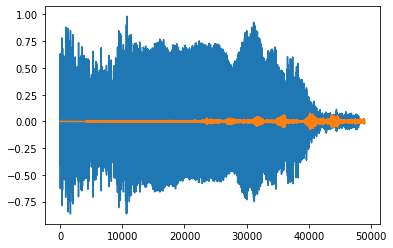

In [5]:
plt.plot(wav_capuchin)
plt.plot(wav_not_capuchin)
plt.show()

Create dataset

Define paths to data files

In [6]:
POS = os.path.join('data','Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

Create datasets

In [7]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

Add labels

In [8]:
positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

Determine average length of bird call

Calculate wave cycle length

In [9]:
lengths = []
for file in os.listdir(POS):
    tensor_wav = load_wav_16k_mono(os.path.join(POS,file))
    lengths.append(len(tensor_wav))

In [10]:
lengths

[40000,
 48000,
 56000,
 48000,
 56000,
 64000,
 64000,
 64000,
 56000,
 56000,
 48000,
 56000,
 64000,
 56000,
 40000,
 64000,
 64000,
 64000,
 64000,
 56000,
 56000,
 56000,
 56000,
 48000,
 48000,
 56000,
 56000,
 64000,
 64000,
 48000,
 56000,
 64000,
 56000,
 64000,
 32000,
 40000,
 48000,
 40000,
 56000,
 56000,
 56000,
 56000,
 48000,
 48000,
 64000,
 64000,
 48000,
 64000,
 48000,
 48000,
 40000,
 48000,
 48000,
 56000,
 56000,
 48000,
 40000,
 56000,
 48000,
 40000,
 56000,
 48000,
 48000,
 56000,
 48000,
 64000,
 64000,
 40000,
 40000,
 72000,
 56000,
 56000,
 56000,
 64000,
 56000,
 64000,
 64000,
 56000,
 56000,
 56000,
 48000,
 48000,
 48000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 56000,
 48000,
 56000,
 40000,
 64000,
 56000,
 56000,
 40000,
 64000,
 56000,
 64000,
 48000,
 64000,
 56000,
 48000,
 48000,
 48000,
 64000,
 64000,
 64000,
 48000,
 48000,
 56000,
 48000,
 64000,
 48000,
 64000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 40000,
 48000,
 48000,


summary stats

In [11]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [12]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [13]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

Preprocessing

build func

In [14]:
def preprocess(file_path,label):
    wav = load_wav_16k_mono(file_path)
    #shorten to around average length
    wav = wav[:48000]
    #pad out shorter calls
    zero_padding = tf.zeros([48000]-tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    
    #build spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram,axis=2)
    return spectrogram, label

test and visualise spectrogram

In [15]:
filepath,label = positives.shuffle(1000).as_numpy_iterator().next()



In [16]:
spectrogram,label = preprocess(filepath,label)

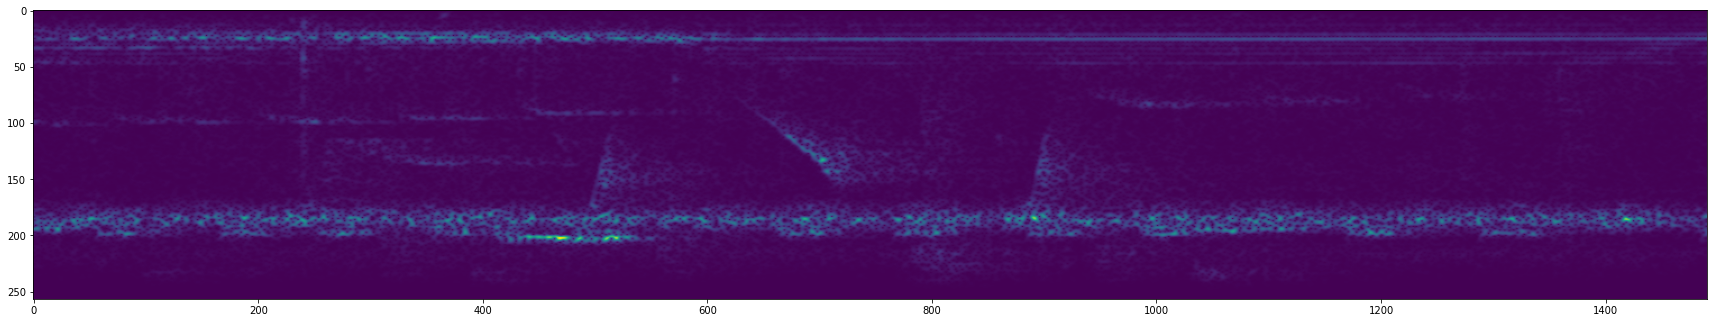

In [17]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Create training and testing partitions

In [18]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(1000)
data = data.batch(16)
data = data.prefetch(8)

In [19]:
#split into test and train
train = data.take(36)
test = data.skip(36).take(15)

In [20]:
samples, labels = train.as_numpy_iterator().next()


In [21]:
samples.shape

(16, 1491, 257, 1)

Build the CNN

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [23]:
#building the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491,257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


Fit model

In [26]:
#hist = model.fit(train, epochs=4, validation_data=test)

In [27]:
#model.save('audioClassifier.h5')

In [28]:
model = tf.keras.models.load_model('audioClassifier.h5')

In [29]:
# plt.title('Loss')
# plt.plot(hist.history['loss'],'r')
# plt.plot(hist.history['val_loss'],'b')
# plt.show()

make a prediction

In [30]:
X_test, y_test = test.as_numpy_iterator().next()

In [31]:
y_hat = model.predict(X_test)

In [32]:
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [33]:
y_hat

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [34]:
y_test

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

Preprocess forest clips

In [35]:
#load up the mp3s
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [36]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [37]:
wav = load_mp3_16k_mono(mp3)

In [38]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000, sequence_stride=48000, batch_size=1)

In [39]:
samples, index = audio_slices.as_numpy_iterator().next()

In [40]:
samples.shape

(1, 48000)

In [41]:
#preprocessing mp3s
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [42]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)
audio_slices


<BatchDataset element_spec=TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None)>

In [48]:
ybar = model.predict(audio_slices)
ybar = [1 if prediction>0.99 else 0 for prediction in ybar]

In [49]:
ybar

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [50]:
from itertools import groupby

ybar = [key for key, group in groupby(ybar)]

In [51]:
ybar

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [54]:
calls = tf.math.reduce_sum(ybar)
calls.numpy()

5

Make predictions on all clips

In [55]:
results = {}

for file in os.listdir(os.path.join('data','Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings',file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

In [56]:
results

{'recording_00.mp3': array([[1.57515854e-01],
        [6.21888041e-02],
        [5.01645207e-02],
        [8.60673189e-01],
        [1.00000000e+00],
        [4.02918458e-03],
        [4.86736894e-02],
        [6.87459111e-02],
        [3.60885561e-02],
        [1.07634276e-01],
        [3.40910256e-02],
        [7.33630657e-02],
        [4.89497483e-02],
        [9.99981582e-01],
        [1.00000000e+00],
        [5.39789498e-02],
        [7.96296808e-05],
        [4.11746502e-02],
        [8.89822245e-02],
        [8.98560584e-02],
        [1.38266593e-01],
        [6.14371300e-02],
        [1.04966730e-01],
        [2.05309480e-01],
        [1.00000000e+00],
        [4.57406044e-03],
        [1.58385634e-02],
        [1.23210520e-01],
        [4.90524173e-02],
        [1.30482256e-01],
        [5.45697212e-02],
        [2.81244159e-01],
        [2.19529867e-03],
        [8.38041306e-04],
        [1.96225971e-01],
        [8.42503607e-02],
        [1.00000000e+00],
        [1.8553260

In [57]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction>0.99 else 0 for prediction in logits]

class_preds


{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [62]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()

postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 19,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 5,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 4,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 4,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 3,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 7,
 'recording_40.mp3': 1,
 'recording_41.

Export results

In [63]:
import csv

In [64]:
with open('capuchinbirdresults.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter = ',')
    writer.writerow(['recording', 'capuchin calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])